In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
def dice_score(y_true, y_pred, label):
    y_true_bin = (y_true == label).astype(np.uint8)
    y_pred_bin = (y_pred == label).astype(np.uint8)
    intersection = np.sum(y_true_bin * y_pred_bin)
    return (2. * intersection) / (np.sum(y_true_bin) + np.sum(y_pred_bin) + 1e-8)

def dice_whole_tumor(y_true, y_pred, new_data=False):
    if new_data:
        labels = [1, 2, 3]
    else:
        labels = [1, 2, 4]
    y_true_bin = np.isin(y_true, labels).astype(np.uint8)
    y_pred_bin = np.isin(y_pred, labels).astype(np.uint8)
    intersection = np.sum(y_true_bin * y_pred_bin)
    return (2. * intersection) / (np.sum(y_true_bin) + np.sum(y_pred_bin) + 1e-8)

def get_id_from_filename(name):
    return name.split("_")[1]

def evaluate(seg_dir, pred_dir, new_data=False):
    if new_data:
        labels = [1, 2, 3]
    else:
        labels = [1, 2, 4]
    results = {}

    for seg_name in tqdm(os.listdir(seg_dir)):
        if not seg_name.endswith(".nii.gz"):
            continue

        case_id = get_id_from_filename(seg_name)
        pred_name = f"{case_id}.nii.gz"

        seg_path = os.path.join(seg_dir, seg_name)
        pred_path = os.path.join(pred_dir, pred_name)

        if not os.path.exists(pred_path):
            print(f"Prediction not found for {case_id}")
            continue

        seg_img = nib.load(seg_path).get_fdata()
        pred_img = nib.load(pred_path).get_fdata()
        if new_data:
            pred_img = np.copy(pred_img)
            pred_img[pred_img == 4] = 3

        case_result = {}
        for l in labels:
            dice = dice_score(seg_img, pred_img, l)
            case_result[f"Dice_label_{l}"] = dice

        wt_dice = dice_whole_tumor(seg_img, pred_img)
        case_result["Dice_whole_tumor"] = wt_dice

        results[case_id] = case_result

    return results

In [5]:
def compute_results(dataset_name):
    seg_dir = f"../brats_data/{dataset_name}/segmentation"
    pred_dir = f"../brats_data/{dataset_name}/output"
    results_dir = f"results"
    results_file = f"{dataset_name}_results.csv"
    new_data = False if dataset_name == "BraTS2021" else True
    results = evaluate(seg_dir, pred_dir, new_data=new_data)

    rows = []
    for case, scores in results.items():
        row = {'Case': case}
        row.update(scores)
        rows.append(row)
        # print(f"{case}:")
        # for label, dice in scores.items():
        #     print(f"  {label}: {dice:.4f}")

    df = pd.DataFrame(rows)
    df.columns = ['Case', 'Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor']
    
    df.to_csv(os.path.join(results_dir, results_file), index=False)
    print(f"Computing for {dataset_name} completed 🟢")

In [6]:
datasets = ["BraTS2021", "BraTS2024-Pre", "BraTS2024-Post", "BraTSafrica"]
for dataset in datasets:
    compute_results(dataset)

100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


Computing for BraTS2021 completed 🟢


100%|██████████| 106/106 [00:18<00:00,  5.88it/s]


Computing for BraTS2024-Pre completed 🟢


100%|██████████| 200/200 [00:36<00:00,  5.54it/s]


Computing for BraTS2024-Post completed 🟢


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]

Computing for BraTSafrica completed 🟢


In [3]:
def plot_segmentation_slice(seg_path, title=None):
    # Load volume
    seg = nib.load(seg_path).get_fdata()
    
    # Find slice with largest tumor area
    sum_per_slice = [np.sum(seg[:, :, i] > 0) for i in range(seg.shape[2])]
    if max(sum_per_slice) == 0:
        print("No tumor found in the volume.")
        return
    best_slice_idx = np.argmax(sum_per_slice)
    seg_slice = seg[:, :, best_slice_idx]

    # Prepare RGB overlay
    rgb = np.zeros(seg_slice.shape + (3,), dtype=np.uint8)

    label_map = {
        1: [255, 0, 0],    # Tumor core – red
        2: [0, 255, 0],    # Edema – green
        4: [0, 0, 255],    # Enhancing tumor – blue
    }

    for label, color in label_map.items():
        rgb[seg_slice == label] = color

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.title(title or f"Segmentation Slice (slice {best_slice_idx})")
    plt.axis('off')
    plt.show()


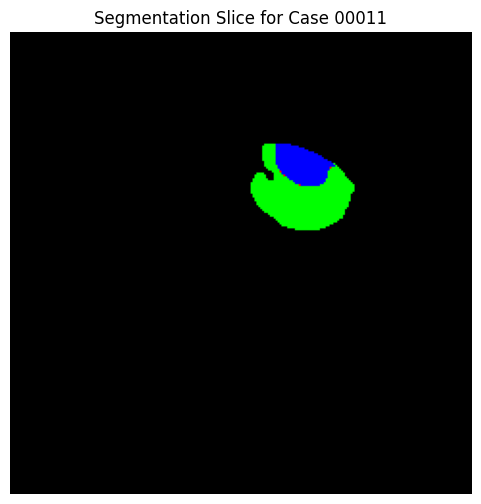

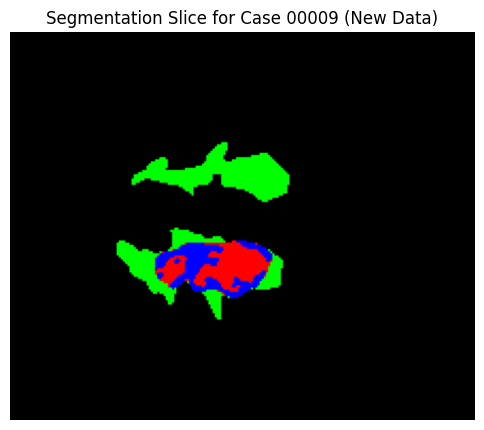

In [4]:
plot_segmentation_slice(seg_path=r'../brats_data/BraTS2021\output\00011.nii.gz', title="Segmentation Slice for Case 00011")
plot_segmentation_slice(seg_path=r'../brats_data/BraTS2024-Post\output\02770.nii.gz', title="Segmentation Slice for Case 00009 (New Data)")

In [24]:
# patients_df = pd.read_csv("patient_data.csv")

# results_df = pd.read_csv("results/BraTS2024-Post_results.csv")
# results_df['patient_id'] = results_df['Case']
# patients_df['patient_id'] = patients_df['id_number'].astype(str)
# results_df['patient_id'] = results_df['patient_id'].astype(str)


# # Merge with patient metadata on patient_id
# merged_df = pd.merge(results_df, patients_df, on='patient_id', how='left')

# # Save merged data for later use
# merged_df.to_csv("results/BraTS2024-Post_with_metadata.csv", index=False)

# print(merged_df.head())


# Averages

In [5]:
brats21 = pd.read_csv('results/BraTS2021_results.csv')
brats24Pre = pd.read_csv('results/BraTS2024-Pre_results.csv')
brats24post = pd.read_csv('results/BraTS2024-Post_with_metadata.csv')
bratsafrica = pd.read_csv('results/BraTSafrica_results.csv')

datasets = {
    'BraTS2021': brats21,
    'BraTS2024-Pre': brats24Pre,
    'BraTS2024-Post': brats24post,
    'BraTSafrica': bratsafrica
}

for dataset_name, df in datasets.items():
    print(f"Dataset: {dataset_name}")
    average_scores = df[['Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor']].mean()
    print(average_scores)
    print("\n")

Dataset: BraTS2021
Tumor core         0.770195
Edema              0.898559
Enhancing tumor    0.885412
Whole tumor        0.950108
dtype: float64


Dataset: BraTS2024-Pre
Tumor core         0.810149
Edema              0.901113
Enhancing tumor    0.888648
Whole tumor        0.924348
dtype: float64


Dataset: BraTS2024-Post
Tumor core         0.134757
Edema              0.681168
Enhancing tumor    0.357096
Whole tumor        0.618212
dtype: float64


Dataset: BraTSafrica
Tumor core         0.585019
Edema              0.816110
Enhancing tumor    0.778807
Whole tumor        0.884895
dtype: float64




# BraTS 2024 Post 

C:\Users\barte\AppData\Local\Temp\ipykernel_17696\886277483.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Glioma type ', y=metric, data=brats24post, palette='pastel')
C:\Users\barte\AppData\Local\Temp\ipykernel_17696\886277483.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Glioma type ', y=metric, data=brats24post, palette='pastel')
C:\Users\barte\AppData\Local\Temp\ipykernel_17696\886277483.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Glioma type ', y=metric, data=brats24post, palette='pastel')
C

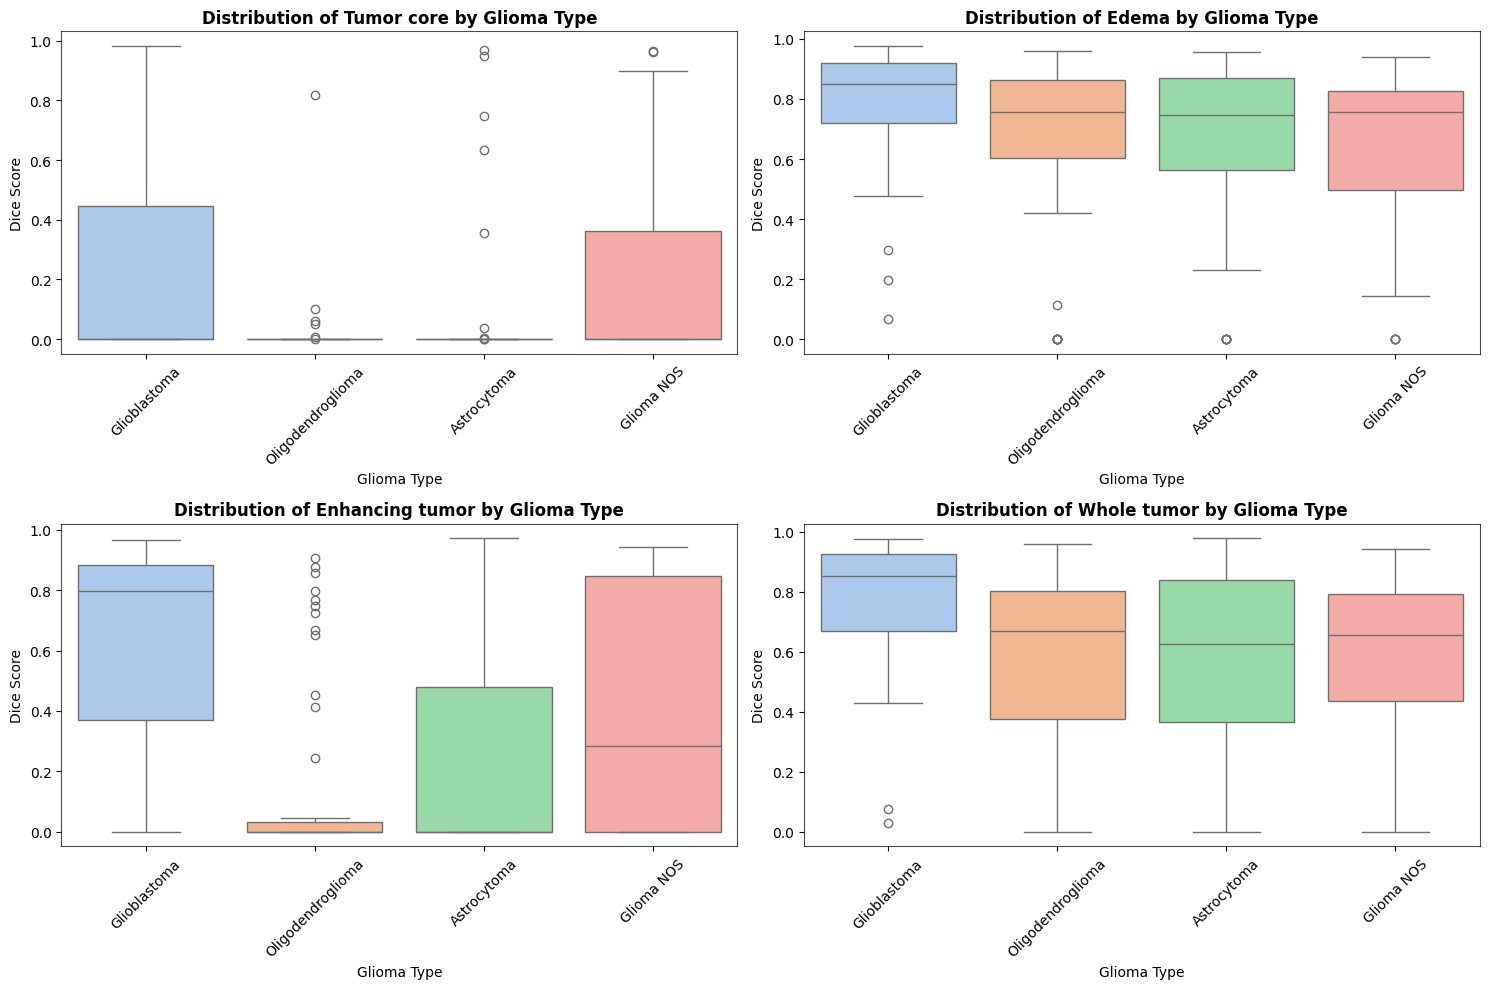

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is loaded into a DataFrame called 'df'
# If not, load it with:
brats24post = pd.read_csv('results/BraTS2024-Post_with_metadata.csv')

# List of tumor metrics to plot
metrics = ['Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor']

# Set the style and configure matplotlib for transparent background and custom text color
plt.rcParams['figure.facecolor'] = 'none'  # Transparent figure background
plt.rcParams['axes.facecolor'] = 'none'    # Transparent axes background
plt.rcParams['savefig.facecolor'] = 'none' # Transparent when saving
plt.rcParams['text.color'] = '#e7bf5f'     # Set default text color
plt.rcParams['axes.labelcolor'] = '#e7bf5f' # Set axis label color
plt.rcParams['xtick.color'] = '#e7bf5f'    # Set x-tick color
plt.rcParams['ytick.color'] = '#e7bf5f'    # Set y-tick color

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    
    ax = sns.boxplot(x='Glioma type ', y=metric, data=brats24post, palette='pastel')
    
    ax.set_facecolor('none')
    
    plt.title(f'Distribution of {metric} by Glioma Type', color='#000000' , fontweight='bold')
    plt.xlabel('Glioma Type', color='#000000' )
    plt.ylabel('Dice Score', color='#000000' )
    
    ax.tick_params(colors='#000000')
    plt.xticks(rotation=45)
    
    for spine in ax.spines.values():
        spine.set_edgecolor('#000000' )
        spine.set_alpha(0.7)

plt.tight_layout()
plt.show()

C:\Users\barte\AppData\Local\Temp\ipykernel_17696\1539259135.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Age Group', y=metric, data=brats24post, palette='pastel')
C:\Users\barte\AppData\Local\Temp\ipykernel_17696\1539259135.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Age Group', y=metric, data=brats24post, palette='pastel')
C:\Users\barte\AppData\Local\Temp\ipykernel_17696\1539259135.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Age Group', y=metric, data=brats24post, palette='pastel')
C:\User

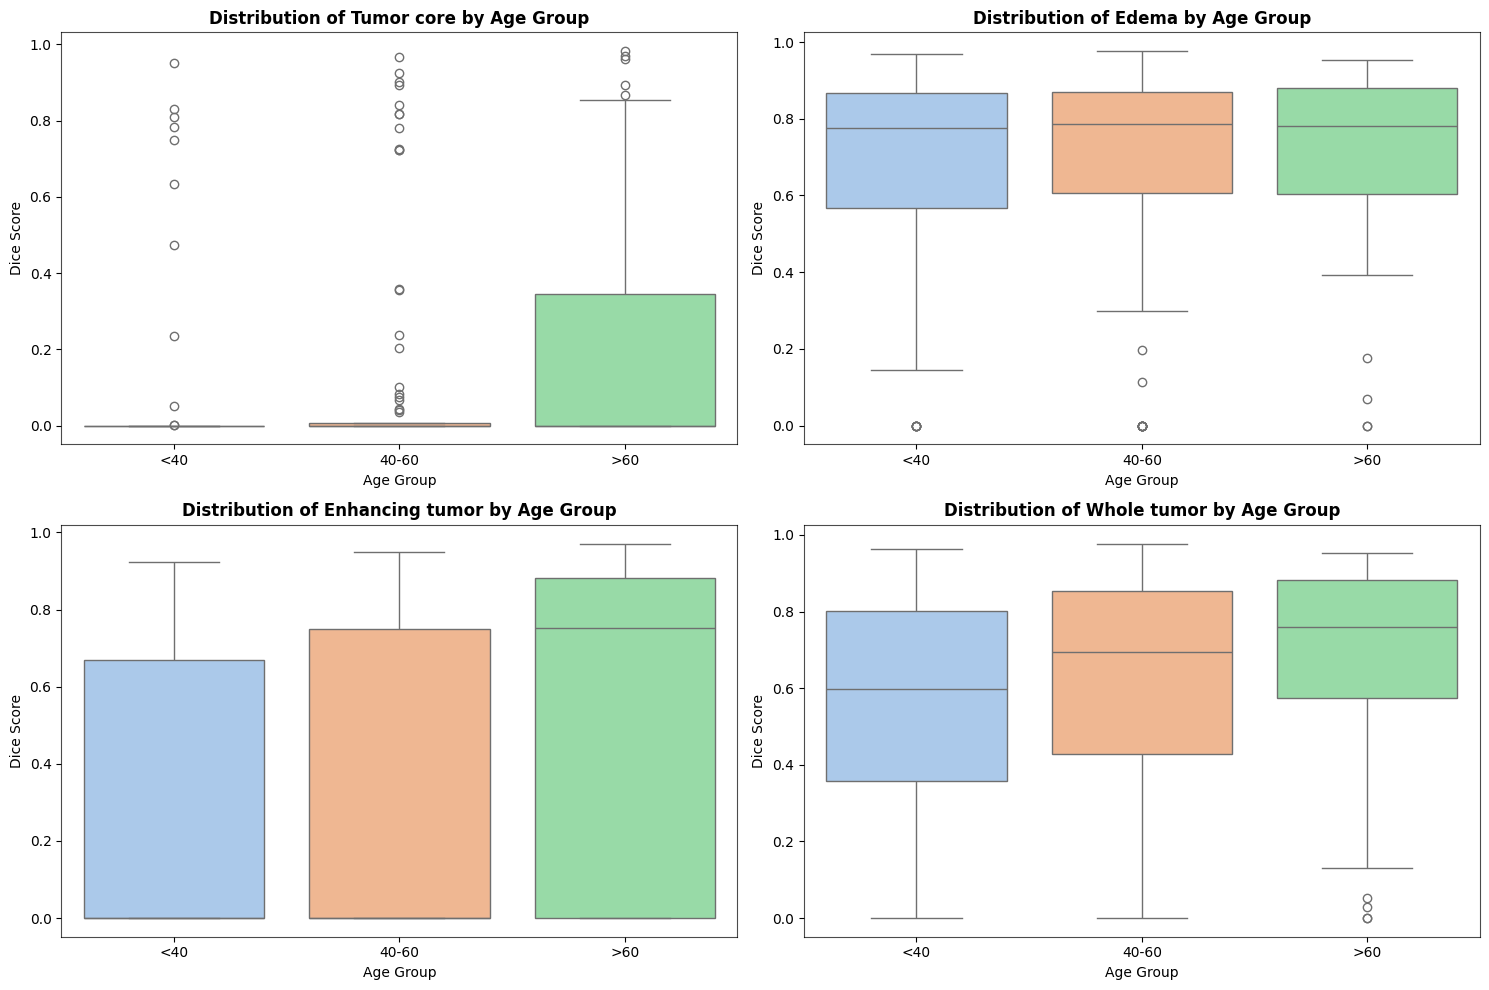

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create age groups
bins = [0, 40, 60, 100]
labels = ['<40', '40-60', '>60']
brats24post['Age Group'] = pd.cut(brats24post["Patient's Age"], bins=bins, labels=labels)

# Tumor metrics to analyze
metrics = ['Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor']

# Set the style and configure matplotlib for transparent background and custom text color
plt.rcParams['figure.facecolor'] = 'none'  # Transparent figure background
plt.rcParams['axes.facecolor'] = 'none'    # Transparent axes background
plt.rcParams['savefig.facecolor'] = 'none' # Transparent when saving
plt.rcParams['text.color'] = '#e7bf5f'     # Set default text color
plt.rcParams['axes.labelcolor'] = '#e7bf5f' # Set axis label color
plt.rcParams['xtick.color'] = '#e7bf5f'    # Set x-tick color
plt.rcParams['ytick.color'] = '#e7bf5f'    # Set y-tick color

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    
    ax = sns.boxplot(x='Age Group', y=metric, data=brats24post, palette='pastel')
    
    ax.set_facecolor('none')
    
    plt.title(f'Distribution of {metric} by Age Group', color='#000000', fontweight='bold')
    plt.xlabel('Age Group', color='#000000')
    plt.ylabel('Dice Score', color='#000000')
    
    ax.tick_params(colors='#000000')
    
    for spine in ax.spines.values():
        spine.set_edgecolor('#000000')
        spine.set_alpha(0.7)

plt.tight_layout()
plt.show()

C:\Users\barte\AppData\Local\Temp\ipykernel_17696\1221230111.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Patient's Sex", y=metric, data=brats24post, palette='pastel')
C:\Users\barte\AppData\Local\Temp\ipykernel_17696\1221230111.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Patient's Sex", y=metric, data=brats24post, palette='pastel')
C:\Users\barte\AppData\Local\Temp\ipykernel_17696\1221230111.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Patient's Sex", y=metric, data=brats24post, palette='past

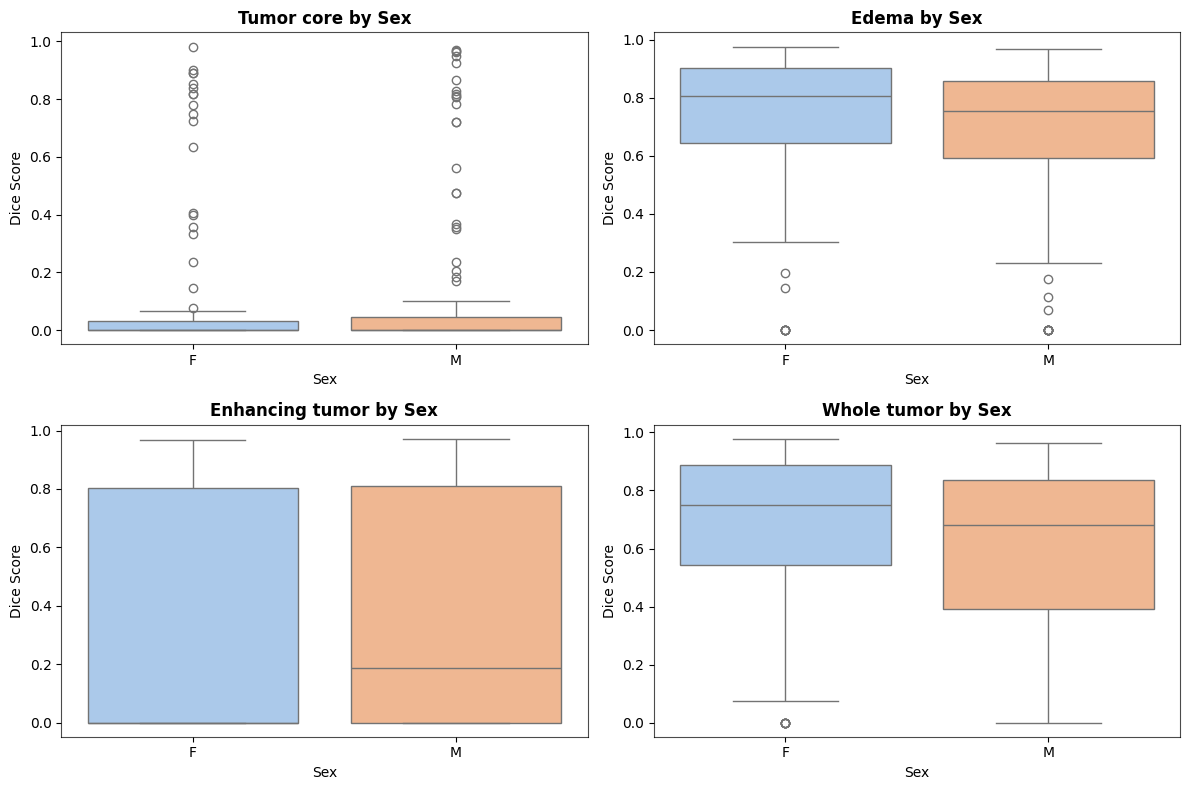

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor']

# Set the style and configure matplotlib for transparent background and custom text color
plt.rcParams['figure.facecolor'] = 'none'  # Transparent figure background
plt.rcParams['axes.facecolor'] = 'none'    # Transparent axes background
plt.rcParams['savefig.facecolor'] = 'none' # Transparent when saving
plt.rcParams['text.color'] = '#e7bf5f'     # Set default text color
plt.rcParams['axes.labelcolor'] = '#e7bf5f' # Set axis label color
plt.rcParams['xtick.color'] = '#e7bf5f'    # Set x-tick color
plt.rcParams['ytick.color'] = '#e7bf5f'    # Set y-tick color

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    
    ax = sns.boxplot(x="Patient's Sex", y=metric, data=brats24post, palette='pastel')
    
    ax.set_facecolor('none')
    
    plt.title(f'{metric} by Sex', color='#000000', fontweight='bold')
    plt.xlabel('Sex', color='#000000')
    plt.ylabel('Dice Score', color='#000000')
    
    ax.tick_params(colors='#000000')
    
    for spine in ax.spines.values():
        spine.set_edgecolor('#000000')
        spine.set_alpha(0.7)

plt.tight_layout()
plt.show()

# BraTS2024-Pre

C:\Users\barte\AppData\Local\Temp\ipykernel_2556\287084491.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='Dice Score', data=df_melted, palette='viridis')


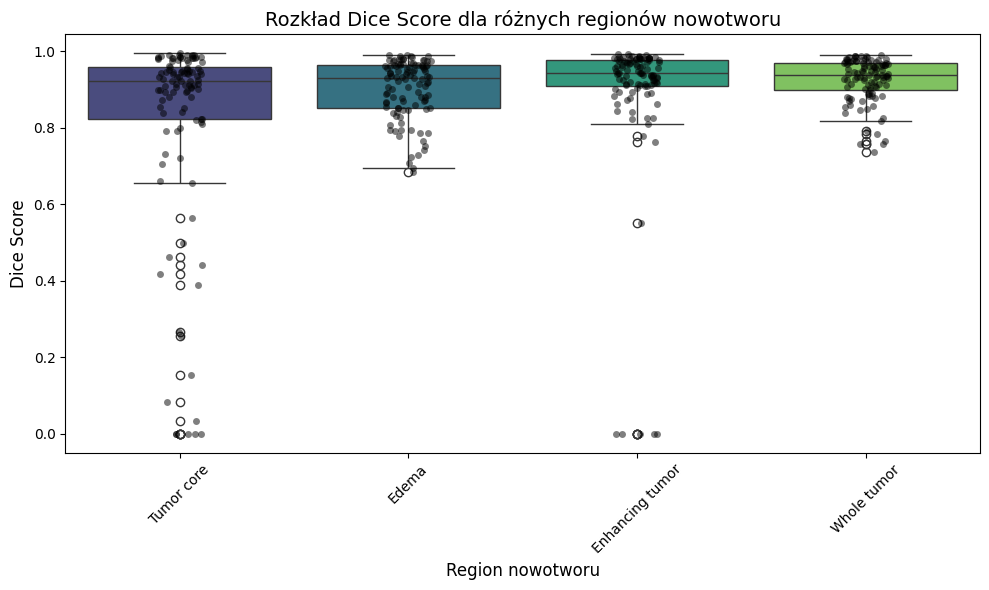

In [28]:
df_melted = brats24Pre.melt(id_vars=['Case'], 
                    value_vars=['Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor'],
                    var_name='Region',
                    value_name='Dice Score')

# Tworzenie boxplotów
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Dice Score', data=df_melted, palette='viridis')
sns.stripplot(x='Region', y='Dice Score', data=df_melted, color='black', alpha=0.5)  # Pokazuje indywidualne przypadki
plt.title('Rozkład Dice Score dla różnych regionów nowotworu', fontsize=14)
plt.xlabel('Region nowotworu', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# BraTS2021

C:\Users\barte\AppData\Local\Temp\ipykernel_2556\1882519831.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='Dice Score', data=df_melted, palette='viridis')


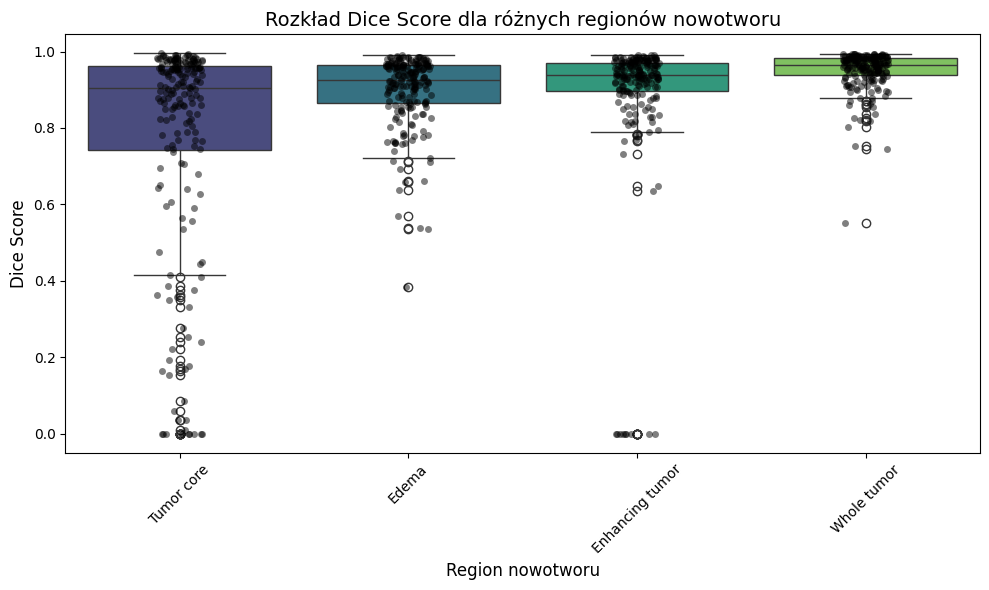

In [29]:
df_melted = brats21.melt(id_vars=['Case'], 
                    value_vars=['Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor'],
                    var_name='Region',
                    value_name='Dice Score')

# Tworzenie boxplotów
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Dice Score', data=df_melted, palette='viridis')
sns.stripplot(x='Region', y='Dice Score', data=df_melted, color='black', alpha=0.5)  # Pokazuje indywidualne przypadki
plt.title('Rozkład Dice Score dla różnych regionów nowotworu', fontsize=14)
plt.xlabel('Region nowotworu', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# BraTS Africa

C:\Users\barte\AppData\Local\Temp\ipykernel_2556\963580857.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='Dice Score', data=df_melted, palette='viridis')


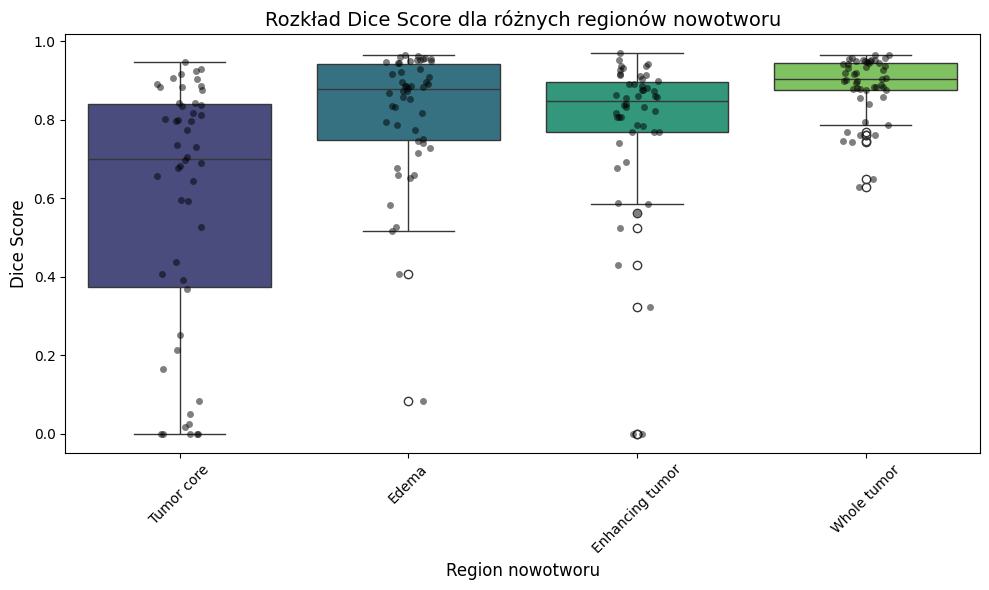

In [30]:
df_melted = bratsafrica.melt(id_vars=['Case'], 
                    value_vars=['Tumor core', 'Edema', 'Enhancing tumor', 'Whole tumor'],
                    var_name='Region',
                    value_name='Dice Score')

# Tworzenie boxplotów
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Dice Score', data=df_melted, palette='viridis')
sns.stripplot(x='Region', y='Dice Score', data=df_melted, color='black', alpha=0.5)  # Pokazuje indywidualne przypadki
plt.title('Rozkład Dice Score dla różnych regionów nowotworu', fontsize=14)
plt.xlabel('Region nowotworu', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()